## Notebook runs multilingual BERT for TASK-1 and TASK-2 on the entire dataset (English + Spanish).

In [ ]:
pip install contractions emoji simpletransformers

In [ ]:
import pandas as pd
import numpy as np
import string
import regex as re
import contractions
import emoji
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [ ]:
def expand_hashtags ( sentences):
        hashtag_pattern = re.compile (r'#([\p{L}0-9\_]+)')
        return sentences.apply (lambda x: re.sub (hashtag_pattern, lambda match: camel_case_split (match.group (1)), x))

def camel_case_split ( identifier):
        # link https://stackoverflow.com/questions/29916065/how-to-do-camelcase-split-in-python/29920015
        matches = re.finditer ('.+?(?:(?<=\p{Ll})(?=\p{Lu})|(?<=\p{Lu})(?=\p{Lu}\p{Ll})|[0-9]+|$)', identifier)
        return ' '.join ([m.group (0) for m in matches])

In [ ]:
def remove_links(s):
    removeLinksPattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',re.DOTALL)
    tmp = re.sub(removeLinksPattern, ' ', s)#, flags = re.DOTALL)
    return tmp 

In [ ]:
def remove_mentions(text):
    begining_mentions_pattern = re.compile (r"^(@[A-Za-z0-9\_]+\s?)+")
    middle_mentions_pattern = re.compile (r'(?<!\b)@([A-Za-z0-9\_]+)\b(?<!user)')
    txt = text.apply (lambda x: re.sub (begining_mentions_pattern, '', x))
    return txt

In [ ]:
def remove_percentages(text):
    percents_pattern = re.compile(r"\b(\d+[\.,]?\d*|\d{2}[AP]M)%")
    #percents_pattern = re.compile(r"(\d+(\.\d+)?%)")
    return text.apply (lambda x: re.sub(percents_pattern, ' ', x))#   re.findall(percents_pattern, text)

def check_percentages(text):
    percents_pattern = re.compile(r"\b(\d+[\.,]?\d*|\d{2}[AP]M)%")
    #percents_pattern = re.compile(r"(\d+(\.\d+)?%)")
    return text.apply (lambda x: re.findall(percents_pattern,  x))#   re.findall(percents_pattern, text)

In [ ]:
def remove_digits (text, replace = '[NUMERO]'):
        digits_pattern = re.compile (r"\b(\d+[\.,]?\d*|\d{2}[AP]M)\b")
        return text.apply (lambda x: re.sub (digits_pattern, replace, x))

In [ ]:
def replace_keep_case (word, replacement, text):
    def func (match):
        g = match.group ()
        if g.islower (): return replacement.lower ()
        if g.istitle (): return replacement.title ()
        if g.isupper (): return replacement.upper ()
        return replacement
    return re.sub (word, func, text)

def remove_elongations (text):
        laughs_pattern = re.compile (r'(?i)\b(mua)?j[ja]+a?\b')
        # Remove laughs
        txt = text.apply (lambda x: re.sub (laughs_pattern, 'jajaja', x))

        
        # Remove exclamatory and interrogative
        for character in ['!', '¡', '?', '¿']:
            pattern = re.compile ('\\' + character + '{2,}')
            txt = txt.apply (lambda x: re.sub (pattern, character, x))
        
        # Add (.)\1{2,}|[aá]{2,}|[eé]{2,}|[ií]{2,}|[oó]{2,}|[uú]{2,})
        elongation_pattern = re.compile (r'(.)\1{2,}')
        # Remove letters longer than 2
        txt = txt.apply (lambda x: re.sub (elongation_pattern, r'\1', x))
        
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[aá]{2,}'), "á", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[eé]{2,}'), "é", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[ií]{2,}'), "í", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[oó]{2,}'), "ó", x))
        txt = txt.apply (lambda x: replace_keep_case (re.compile (r'(?i)[uú]{2,}'), "ú", x))
        return txt

In [ ]:
def remove_emojis (text):
        return text.apply (lambda x: emoji.get_emoji_regexp ().sub (u'', x))

In [ ]:
def remove_quotations (text):
        quotations_pattern = r'["“”\'«»‘’]'
        return text.replace (to_replace = quotations_pattern, value = '', regex = True)

In [ ]:
def remove_punctuation (text):
    punctuation_pattern = re.compile ("[" + re.escape(string.punctuation) + "]")
    #print(punctuation_pattern)
    punc = text.apply (lambda x: re.findall(punctuation_pattern,  x))
    #print(punc)
    return text.apply (lambda x: re.sub (punctuation_pattern, '', x))

In [ ]:
def preprocessData(text):
  txt = expand_hashtags(text)
  txt = txt.apply(lambda x: remove_links(x))
  txt = remove_mentions(txt)
  txt = remove_percentages(txt)
  txt = remove_digits(txt)
  txt = remove_elongations(txt)
  txt = remove_emojis(txt)
  txt = txt.str.lower()
  txt = remove_quotations(txt)
  txt = remove_punctuation(txt)
  txt = txt.apply(lambda x: x.strip())
  return txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_training.tsv", sep="\t")
test_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_test_labeled.tsv", sep="\t")

### **Preprocessing**

In [ ]:
train_data.text = preprocessData(train_data.text)
test_data.text = preprocessData(test_data.text)

In [ ]:
train_data.head(5)

,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,she calls herself antifeminazi how about shut ...,sexist,ideological-inequality
1,EXIST2021,2,twitter,en,now back to these women the brave and the beau...,non-sexist,non-sexist
2,EXIST2021,3,twitter,en,wow your skirt is very short what is its lengt...,sexist,objectification
3,EXIST2021,4,twitter,en,incredible beautifulbut i laughed so much whe...,non-sexist,non-sexist
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


In [ ]:
train_data.loc[train_data['language'] == 'es'].head(5)

,test_case,id,source,language,text,task1,task2
3436,EXIST2021,3437,twitter,es,nadie te va a tratar tan bien como un hombre q...,sexist,sexual-violence
3437,EXIST2021,3438,twitter,es,que rica putita obediente afortunado tu marido...,sexist,stereotyping-dominance
3438,EXIST2021,3439,twitter,es,yo lo hice a los numero años por la carretera ...,non-sexist,non-sexist
3439,EXIST2021,3440,twitter,es,las cosas q sueño son indicios de que yo enrea...,non-sexist,non-sexist
3440,EXIST2021,3441,twitter,es,pero a la niña le gustó desde que lo vió así q...,non-sexist,non-sexist


In [ ]:
test_data.head(5)

,test_case,id,source,language,text,task1,task2
0,EXIST2021,6978,gab,en,pennsylvania state rep horrifies with opening ...,non-sexist,non-sexist
1,EXIST2021,6979,twitter,en,he sounds like as ass and very condescending,non-sexist,non-sexist
2,EXIST2021,6980,twitter,en,lol this behavior of not letting men tell you ...,sexist,ideological-inequality
3,EXIST2021,6981,twitter,en,rightsi mean yeah most women especially the wo...,sexist,ideological-inequality
4,EXIST2021,6982,twitter,en,the jack manifold appreciation im séing is on ...,non-sexist,non-sexist


In [ ]:
test_data.loc[test_data['language'] == 'es'].head(5)

,test_case,id,source,language,text,task1,task2
2208,EXIST2021,9186,gab,es,y te golpeo más fuerte perra,sexist,misogyny-non-sexual-violence
2209,EXIST2021,9187,twitter,es,castigado tres meses sin salir y la chica no v...,non-sexist,non-sexist
2210,EXIST2021,9188,twitter,es,jajaja el me he topado con tantos de la onda n...,sexist,stereotyping-dominance
2211,EXIST2021,9189,twitter,es,resulta que hoy es el día de la juventud y no ...,non-sexist,non-sexist
2212,EXIST2021,9190,twitter,es,los que dicen que crén en la igualdad pero que...,sexist,ideological-inequality


In [ ]:
encoder_task1 = LabelBinarizer()
encoder_task1.fit(train_data['task1'])
transformed = encoder_task1.transform(train_data['task1'])
train_data['label-task-1'] = pd.DataFrame(transformed)

encoder_task1.fit(test_data['task1'])
transformed = encoder_task1.transform(test_data['task1'])
test_data['label-task-1'] = pd.DataFrame(transformed)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6977 entries, 0 to 6976
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   test_case     6977 non-null   object
 1   id            6977 non-null   int64 
 2   source        6977 non-null   object
 3   language      6977 non-null   object
 4   text          6977 non-null   object
 5   task1         6977 non-null   object
 6   task2         6977 non-null   object
 7   label-task-1  6977 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 436.2+ KB


## Multilingual BERT for Task 1

In [ ]:
print(train_data.shape, test_data.shape)

(6977, 8) (4368, 8)


### Class size in train data

In [ ]:
train_data.groupby(['task1']).size()

task1
non-sexist    3600
sexist        3377
dtype: int64

### Class size in test data

In [ ]:
test_data.groupby(['task1']).size()

task1
non-sexist    2087
sexist        2281
dtype: int64

### dropping useless columns

In [ ]:
train_data = train_data.drop(["test_case", "source", "language", "id"], axis = 1)
test_data = test_data.drop(["test_case", "source", "language", "id"], axis = 1)

### Creating binary labels for task - 1 for both train and test data

In [ ]:
encoder_task1 = LabelBinarizer()
encoder_task1.fit(train_data['task1'])
transformed = encoder_task1.transform(train_data['task1'])
train_data['label-task-1'] = pd.DataFrame(transformed)

transformed = encoder_task1.transform(test_data['task1'])
test_data['label-task-1'] = pd.DataFrame(transformed)

In [ ]:
train_data.head(5)

,text,task1,task2,label-task-1
0,she calls herself antifeminazi how about shut ...,sexist,ideological-inequality,1
1,now back to these women the brave and the beau...,non-sexist,non-sexist,0
2,wow your skirt is very short what is its lengt...,sexist,objectification,1
3,incredible beautifulbut i laughed so much whe...,non-sexist,non-sexist,0
4,i find it extremely hard to believe that kelly...,non-sexist,non-sexist,0


In [ ]:
test_data.head(5)

,text,task1,task2,label-task-1
0,pennsylvania state rep horrifies with opening ...,non-sexist,non-sexist,0
1,he sounds like as ass and very condescending,non-sexist,non-sexist,0
2,lol this behavior of not letting men tell you ...,sexist,ideological-inequality,1
3,rightsi mean yeah most women especially the wo...,sexist,ideological-inequality,1
4,the jack manifold appreciation im séing is on ...,non-sexist,non-sexist,0


In [ ]:
model_task1 = ClassificationModel( 'bert', 'bert-base-multilingual-uncased', args={'train_batch_size':4, 'learning_rate': 3e-5, 'num_train_epochs': 1, 'max_seq_length': 512, 'overwrite_output_dir': True})

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [ ]:
model_task1.train_model(train_data[['text','label-task-1']])

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/6977 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1745 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:922: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm


(1745, 0.6283670004595999)

In [ ]:
result, model_outputs, wrong_predictions = model_task1.eval_model(test_data[['text','label-task-1']])

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/4368 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/546 [00:00<?, ?it/s]

In [ ]:
result

{'mcc': 0.43910439839999216,
 'tp': 1683,
 'tn': 1463,
 'fp': 624,
 'fn': 598,
 'auroc': 0.7775039822940998,
 'auprc': 0.7496860953992994,
 'eval_loss': 0.5957893399528531}

In [ ]:
def display_classification_stats(result):
  confusion_matrix = np.zeros((2,2))
  confusion_matrix[0][0] = result['tn']
  confusion_matrix[0][1] = result['fp']
  confusion_matrix[1][0] = result['fn']
  confusion_matrix[1][1] = result['tp']


  precision =  result['tp'] / ( result['tp'] + result['fp'] )
  recall = result['tp'] / ( result['tp'] + result['fn'] )
  F_score =  2 * precision * recall / (precision + recall)
  accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1])/np.sum(confusion_matrix)
  print("ACCURACY  : ", accuracy)
  print("PRECISION : ", precision)
  print("RECALL    : ", recall)
  print("F1        : ", F_score)

  print(confusion_matrix)
  ax= plt.subplot()
  sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  #ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['non-sexism', 'sexism']); ax.yaxis.set_ticklabels(['non-sexism', 'sexism']);

ACCURACY  :  0.7202380952380952
PRECISION :  0.729518855656697
RECALL    :  0.7378342832091188
F1        :  0.7336530078465562
[[1463.  624.]
 [ 598. 1683.]]


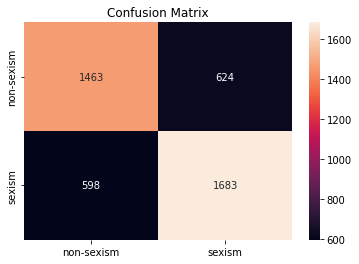

In [ ]:
display_classification_stats(result)

In [ ]:
predictions, raw_outputs = model_task1.predict(list(test_data.text.values))

  0%|          | 0/4368 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

In [ ]:
print('Accuracy on Test Data:', accuracy_score(test_data['label-task-1'],predictions))
print('F1-Score on Test Data:', f1_score(test_data['label-task-1'],predictions))
print('Confusion Matrix on Test Data:\n', confusion_matrix(test_data['label-task-1'],predictions))
print('Classification on Test Data:\n', classification_report(test_data['label-task-1'],predictions))

Accuracy on Test Data: 0.7202380952380952
F1-Score on Test Data: 0.7336530078465562
Confusion Matrix on Test Data:
 [[1463  624]
 [ 598 1683]]
Classification on Test Data:
               precision    recall  f1-score   support

           0       0.71      0.70      0.71      2087
           1       0.73      0.74      0.73      2281

    accuracy                           0.72      4368
   macro avg       0.72      0.72      0.72      4368
weighted avg       0.72      0.72      0.72      4368



##Task 2

In [ ]:
train_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_training.tsv", sep="\t")
test_data = pd.read_csv("/content/drive/My Drive/SEXISM DATA/EXIST2021_test_labeled.tsv", sep="\t")

train_data = train_data[train_data.task2 != 'non-sexist']
test_data = test_data[test_data.task2 != 'non-sexist']

d = {
    'ideological-inequality'       : 0,         
    'misogyny-non-sexual-violence' : 1,    
    'objectification'              : 2,   
    'sexual-violence'              : 3,   
    'stereotyping-dominance'       : 4   
}

train_data = train_data.replace({"task2": d})
test_data = test_data.replace({"task2": d})

train_data = train_data.drop(["test_case", "source", "language", "id", "task1"], axis = 1)
test_data = test_data.drop(["test_case", "source", "language", "id", "task1"], axis = 1)

train_data.text = preprocessData(train_data.text)
test_data.text = preprocessData(test_data.text)

In [ ]:
train_data.head()

,text,task2
0,she calls herself antifeminazi how about shut ...,0
2,wow your skirt is very short what is its lengt...,2
5,hellom rajm with gód size and excellent stamin...,3
10,you werent actually whatthis is not a painted ...,0
15,i dont know any feminists who think the way yo...,0


In [ ]:
test_data.head()

,text,task2
2,lol this behavior of not letting men tell you ...,0
3,rightsi mean yeah most women especially the wo...,0
7,stop regarding women as animals who forget tht...,0
8,yeah it is rough but not for women married wom...,2
11,you were publicly harassing a girl by constant...,1


In [ ]:
train_data.groupby(['task2']).size()

task2
0    866
1    685
2    500
3    517
4    809
dtype: int64

In [ ]:
train_data.groupby(['task2']).size()

task2
0    866
1    685
2    500
3    517
4    809
dtype: int64

In [ ]:
model_task2 = ClassificationModel( 'bert', 'bert-base-multilingual-uncased', num_labels=5 ,args={'train_batch_size':4, 'learning_rate': 3e-5, 'num_train_epochs': 1, 'max_seq_length': 512, 'overwrite_output_dir': True})

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [ ]:
model_task2.train_model(train_data)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3377 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/845 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:922: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm


(845, 1.233455391607341)

In [ ]:
result, model_outputs, wrong_predictions = model_task2.eval_model(test_data)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2281 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/286 [00:00<?, ?it/s]

In [ ]:
result

{'mcc': 0.49749646373976897, 'eval_loss': 1.0418175784024326}

In [ ]:
predictions, raw_outputs = model_task2.predict(list(test_data.text.values))

  0%|          | 0/2281 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

In [ ]:
def display_classification_stats_task2(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    target_names = ['ideological\ninequality', 'misogyny\nnon-sexual\nviolence', 'objectification', 'sexual\nviolence', 'stereotyping\ndominance' ]
    target_names2 = ['ideological inequality', 'misogyny non-sexual violence', 'objectification', 'sexual violence', 'stereotyping dominance' ]
    print(classification_report(y_true, y_pred, target_names=target_names2))
    plt.figure(figsize = (15,10))
    ax= plt.subplot()
    sns.heatmap(cf, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    #ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(target_names,rotation=0, fontsize="17")
    ax.yaxis.set_ticklabels(target_names, rotation=0, fontsize="17")

                              precision    recall  f1-score   support

      ideological inequality       0.74      0.75      0.74       621
misogyny non-sexual violence       0.52      0.49      0.50       472
             objectification       0.54      0.44      0.48       324
             sexual violence       0.68      0.61      0.64       400
      stereotyping dominance       0.50      0.64      0.56       464

                    accuracy                           0.60      2281
                   macro avg       0.60      0.58      0.59      2281
                weighted avg       0.61      0.60      0.60      2281



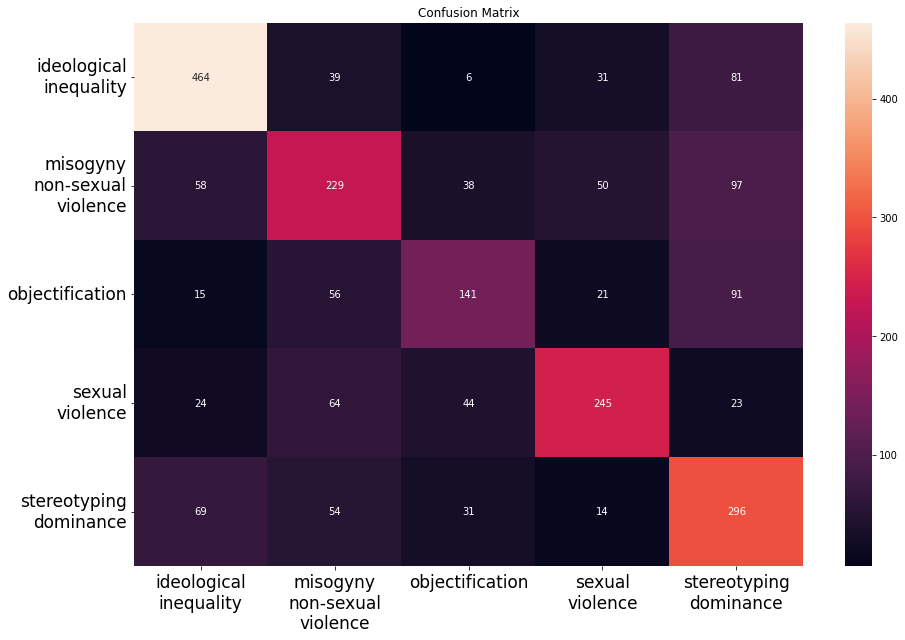

In [ ]:
y_true = test_data.task2.values
y_pred = predictions
display_classification_stats_task2(y_true, y_pred)